In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import scipy.signal
from matplotlib.animation import FuncAnimation
from moviepy import VideoFileClip, AudioFileClip

MoviePy - Building video CANETA_AZUL_FINAL.mp4.
MoviePy - Writing audio in CANETA_AZUL_FINALTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
MoviePy - Writing video CANETA_AZUL_FINAL.mp4



MoviePy - Done !
MoviePy - video ready CANETA_AZUL_FINAL.mp4


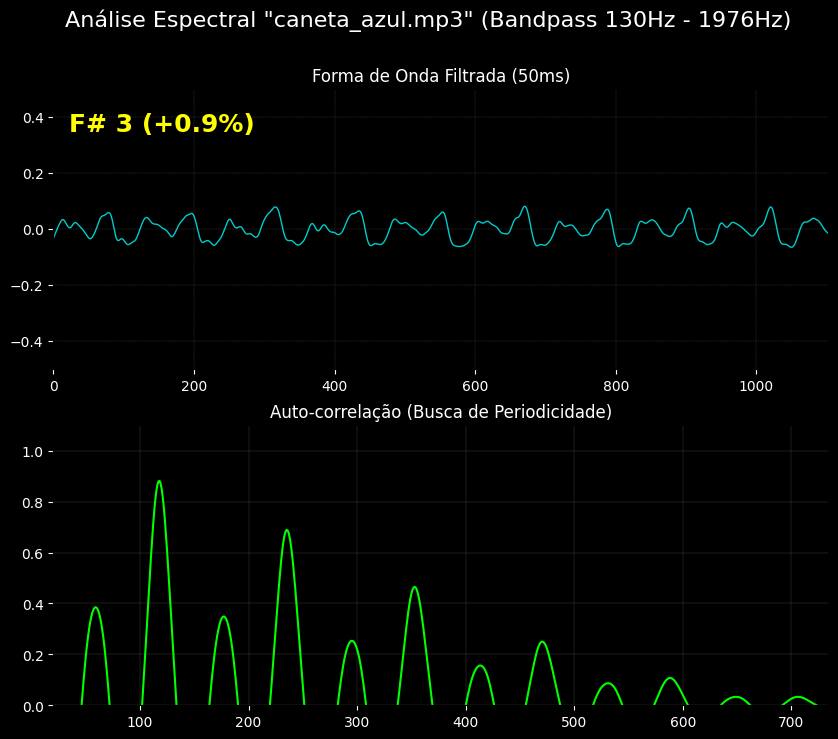

In [3]:
ARQUIVO_AUDIO = "caneta_azul.mp3" 
JANELA_MS = 50 

NOTAS_REFERENCIA = np.array([
    # Oitava 2
    [130.81, "C 2"], [138.59, "C# 2"], [146.83, "D 2"], [155.56, "D# 2"], 
    [164.81, "E 2"], [174.61, "F 2"], [185.00, "F# 2"], [196.00, "G 2"], 
    [207.65, "G# 2"], [220.00, "A 2"], [233.08, "A# 2"], [246.94, "B 2"],
    # Oitava 3
    [261.63, "C 3"], [277.18, "C# 3"], [293.66, "D 3"], [311.13, "D# 3"], 
    [329.63, "E 3"], [349.23, "F 3"], [370.00, "F# 3"], [392.00, "G 3"], 
    [415.30, "G# 3"], [440.00, "A 3"], [466.16, "A# 3"], [493.88, "B 3"],
    # Oitava 4
    [523.25, "C 4"], [554.37, "C# 4"], [587.33, "D 4"], [622.25, "D# 4"], 
    [659.26, "E 4"], [698.46, "F 4"], [740.00, "F# 4"], [783.99, "G 4"], 
    [830.61, "G# 4"], [880.00, "A 4"], [932.33, "A# 4"], [987.77, "B 4"],
    # Oitava 5
    [1046.50, "C 5"], [1108.73, "C# 5"], [1174.66, "D 5"], [1244.51, "D# 5"], 
    [1318.51, "E 5"], [1396.91, "F 5"], [1480.00, "F# 5"], [1567.98, "G 5"], 
    [1661.22, "G# 5"], [1760.00, "A 5"], [1864.65, "A# 5"], [1975.53, "B 5"],
])

def encontrar_nota(frequencia_detectada):
    if frequencia_detectada is None or frequencia_detectada < 50: return "..."
    diferencas = np.abs(NOTAS_REFERENCIA[:, 0].astype(float) - frequencia_detectada)
    idx = diferencas.argmin()
    nota_nome = NOTAS_REFERENCIA[idx, 1]
    nota_freq = float(NOTAS_REFERENCIA[idx, 0])
    desvio = ((frequencia_detectada / nota_freq) - 1) * 100
    sinal = "+" if desvio > 0 else ""
    return f"{nota_nome} ({sinal}{desvio:.1f}%)"


y_raw, sr = librosa.load(ARQUIVO_AUDIO, sr=22050)
FILTER = (130,1976)

sos = scipy.signal.butter(4, FILTER, btype='bandpass', fs=sr, output='sos')
y = scipy.signal.sosfilt(sos, y_raw)

amostras_por_janela = int(sr * (JANELA_MS / 1000))
total_janelas = len(y) // amostras_por_janela


fig, (ax_wave, ax_corr) = plt.subplots(2, 1, figsize=(10, 8), facecolor='black')
fig.suptitle(f'Análise Espectral "{ARQUIVO_AUDIO}" (Bandpass {FILTER[0]}Hz - {FILTER[1]}Hz)', fontsize=16, color='white')


ax_wave.set_facecolor('black')
line_wave, = ax_wave.plot([], [], color='cyan', alpha=0.8, linewidth=1)
ax_wave.set_title(f'Forma de Onda Filtrada ({JANELA_MS}ms)', color='white')
ax_wave.tick_params(colors='white')

ax_wave.set_ylim(-0.5, 0.5) 
ax_wave.set_xlim(0, amostras_por_janela)
ax_wave.grid(True, linestyle='--', linewidth=0.3, color='#444444')


ax_corr.set_facecolor('black')
line_corr, = ax_corr.plot([], [], color='lime', linewidth=1.5)
peak_marker, = ax_corr.plot([], [], 'ro', markersize=8)
ax_corr.set_title('Auto-correlação (Busca de Periodicidade)', color='white')
ax_corr.tick_params(colors='white')

ax_corr.set_ylim(0, 1.1) 
ax_corr.set_xlim(20, amostras_por_janela // 1.5) 
ax_corr.grid(True, linestyle='-', linewidth=0.3, color='#444444')

nota_texto = ax_wave.text(0.02, 0.85, '', transform=ax_wave.transAxes, color='yellow', fontsize=18, fontweight='bold')


def update(frame_idx):
    start = frame_idx * amostras_por_janela
    end = start + amostras_por_janela
    fatia_audio = y[start:end]

    if len(fatia_audio) < amostras_por_janela:
        fatia_audio = np.pad(fatia_audio, (0, amostras_por_janela - len(fatia_audio)))

    fatia_suavizada = fatia_audio * np.hanning(len(fatia_audio))

    line_wave.set_data(np.arange(len(fatia_audio)), fatia_audio)

    corr = scipy.signal.fftconvolve(fatia_suavizada, fatia_suavizada[::-1], mode='full')
    corr = corr[len(corr)//2:] # Pega só a metade positiva

    max_val = np.max(corr)
    if max_val > 0:
        corr = corr / max_val
    else:
        corr = np.zeros_like(corr)

    line_corr.set_data(np.arange(len(corr)), corr)


    frequencia_fundamental = None
    pico_x, pico_y = 0, 0

    lag_min = int(sr / 800) 

    peaks, props = scipy.signal.find_peaks(corr, height=0.2, prominence=0.1, distance=lag_min)

    peaks = peaks[peaks > lag_min]

    if len(peaks) > 0:
        idx_pico = peaks[0]

        if 0 < idx_pico < len(corr) - 1:
            alpha = corr[idx_pico-1]
            beta = corr[idx_pico]
            gamma = corr[idx_pico+1]
            offset = 0.5 * (alpha - gamma) / (alpha - 2*beta + gamma)
            idx_real = idx_pico + offset
        else:
            idx_real = idx_pico

        periodo_s = idx_real / sr
        frequencia_fundamental = 1 / periodo_s

    peak_marker.set_data([pico_x], [pico_y])
    nota_detectada = encontrar_nota(frequencia_fundamental)
    nota_texto.set_text(nota_detectada) 

    return line_wave, line_corr, peak_marker, nota_texto

ani = FuncAnimation(fig, update, frames=total_janelas, interval=JANELA_MS, blit=True)
ani.save("temp_video.mp4", fps=1000/JANELA_MS, dpi=80) 

video = VideoFileClip("temp_video.mp4")
audio = AudioFileClip(ARQUIVO_AUDIO)

new_audio = audio.subclipped(0, video.duration)
final = video.with_audio(new_audio)

final.write_videofile("CANETA_AZUL_FINAL.mp4", codec='libx264', audio_codec='aac', fps=24)